In [1]:
from HotVisFunctions import *
import csv

/opt/conda/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
def shortest_paths_path_data(path_data: pp.PathData):

    # create distance matrix for all nodes: default vakue is 'inf'
    dist = torch.full((path_data.data.dag_num_nodes[0] + 1, path_data.data.dag_num_nodes[0] + 1), float('inf'))

    # create second order model
    mo_graph = pp.MultiOrderModel.from_PathData(path_data, max_order=2, cached=False).layers[2]
    # get distances of second order model
    mo_dist, _ = pp.algorithms.shortest_paths.shortest_paths_dijkstra(mo_graph)
    # iterate through values over diagonal of adjancecy matrix
    for i in range(mo_dist.shape[0]):
        for j in range(i+1, mo_dist.shape[0]):
            # get node ids
            node_i = mo_graph.mapping.node_ids[i]
            node_j = mo_graph.mapping.node_ids[j]
            # write distance into 'dist'
            dist[path_data.mapping.to_idx(node_i[0]), path_data.mapping.to_idx(node_j[1])] = mo_dist[i,j] + 1

    # iterate through values over diagonal of adjancecy matrix
    for j in range(mo_dist.shape[0]):
        for i in range(j+1, mo_dist.shape[0]):
            # get node ids
            node_i = mo_graph.mapping.node_ids[i]
            node_j = mo_graph.mapping.node_ids[j]
            # write distance into 'dist'
            dist[path_data.mapping.to_idx(node_i[0]), path_data.mapping.to_idx(node_j[1])] = mo_dist[i,j] + 1
    
    # insert all distances of length 1
    for node in mo_graph.nodes:
        dist[path_data.mapping.to_idx(node[0]), path_data.mapping.to_idx(node[1])] = 1

    # fill diagonals with 0
    torch.Tensor.fill_diagonal_(dist, 0)

    return dist

In [4]:
g = pp.Graph.from_edge_list([('a', 'b'), ('b','c'), ('b','d')])
test_path_data = pp.PathData(g.mapping)
test_path_data.append_walk(('a', 'b', 'c'))
test_path_data.append_walk(('b', 'd'))
test_path_data.append_walk(('b', 'a'))

test_temp_graph =pp.TemporalGraph.from_edge_list([('a', 'b', 1), ('b', 'c', 1), ('b', 'a', 2), ('b', 'd', 1)])
dist, _ = pp.algorithms.temporal_shortest_paths(test_temp_graph, 1)
print(dist)
print(test_temp_graph.mapping)
print(shortest_paths_path_data(test_path_data))

100%|██████████| 2/2 [00:00<00:00, 775.43it/s]

[[ 0.  1. inf  2.]
 [ 1.  0.  1.  1.]
 [inf inf  0. inf]
 [inf inf inf  0.]]
a -> 0
b -> 1
c -> 2
d -> 3



('a', 'b') -> 0
('b', 'a') -> 1
('b', 'c') -> 2
('b', 'd') -> 3

tensor([[0., 1., 2., inf],
        [1., 0., 1., 1.],
        [inf, inf, 0., inf],
        [inf, inf, inf, 0.]])


In [7]:
def stress_loss(layout: torch.nn.Embedding|torch.Tensor, shortest_path_dist: torch.Tensor) -> float:
    loss = 0

    if isinstance(layout, torch.nn.Embedding):
        for i in range(layout.num_embeddings):
            for j in range(i + 1, layout.num_embeddings):
                delta = layout(torch.tensor(i)) - layout(torch.tensor(j))
                distance = torch.norm(delta)
                loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  

    elif isinstance(layout, torch.Tensor):
        for i in range(layout.shape[0]):
            for j in range(i + 1, layout.shape[0]):
                delta = layout[i] - layout[j]
                distance = torch.norm(delta)
                loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  
    else:
        return None

    return loss


def SGD_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None) -> dict:

    # Hier noch PathData version einfügen
    graph = data

    dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)

    # Fehlt: initial positions

    # initialize embedding
    num_nodes =  graph.N 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.N, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and lossfunction
    optimizer = torch.optim.SGD(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Fortschritt anzeigen
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")

    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout


def Adam_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None):

    # Hier noch PathData version einfügen
    graph = data

    dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)

    # Fehlt: initial positions

    # initialize embedding
    num_nodes =  graph.N 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.N, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and lossfunction
    optimizer = torch.optim.Adam(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Fortschritt anzeigen
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")

    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout



In [8]:
def SGD_stress_paper(data: pp.TemporalGraph|pp.PathData, iterations: int, delta:int = 1, initial_positions: torch.Tensor | None = None, learning_rate: float = 0.01, eta: float = 1, decay: float = 0.5) -> dict:
    # Hier noch PathData version einfügen
    graph = data

    dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)

    if initial_positions is None:
        initial_positions = torch.rand((graph.N, 2))*100
    
    positions = torch.clone(initial_positions)

    node_pairs = torch.combinations(torch.arange(graph.N), r=2, with_replacement=False)

    for i in range(iterations):
        shuffled_pairs = node_pairs[torch.randperm(node_pairs.size(0))]
        step_width = eta * torch.exp(torch.tensor(-decay * i))

        for pair in shuffled_pairs:
            shortest_path_dist = dist[pair[0], pair[1]]
            if(shortest_path_dist == 0):
               continue
            learning_rate = min(1, ((1 / (shortest_path_dist ** 2)) * step_width)) / 2
            norm = torch.norm(positions[pair[0]] - positions[pair[1]])
            delta = (norm - shortest_path_dist) / norm * (positions[pair[0]] - positions[pair[1]])
            positions[pair[0]] -= learning_rate * delta
            positions[pair[1]] += learning_rate * delta

        # Fortschritt anzeigen
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Stress: {stress_loss(positions, dist):.4f}")

    layout = {}
    for node in graph.nodes:
        layout[node] = positions[graph.mapping.to_idx(node)].tolist()

    return layout

In [4]:
graph = pp.io.read_csv_temporal_graph('graphs/synthetic_graph/temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')
# read colors
colors = {}
with open('graphs/synthetic_graph/colors.csv', mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Überspringt die Kopfzeile
    for row in reader:
        number, color = row
        colors[number] = color
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1

In [11]:
layout_paper = SGD_stress_paper(graph, iterations=30, delta = 1, learning_rate=0.01)
layout_adam = Adam_stress_torch(graph, iterations=500, delta = 1, learning_rate=0.5)
layout_torch = SGD_stress_torch(graph, iterations=100, delta = 1, learning_rate=0.01)



100%|██████████| 20000/20000 [00:16<00:00, 1225.74it/s]


KeyboardInterrupt: 

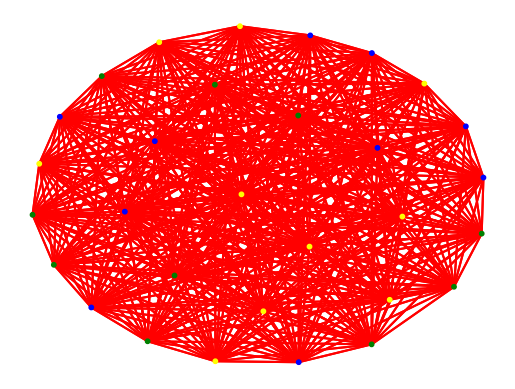

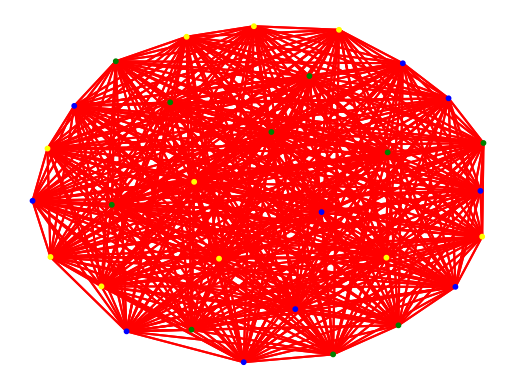

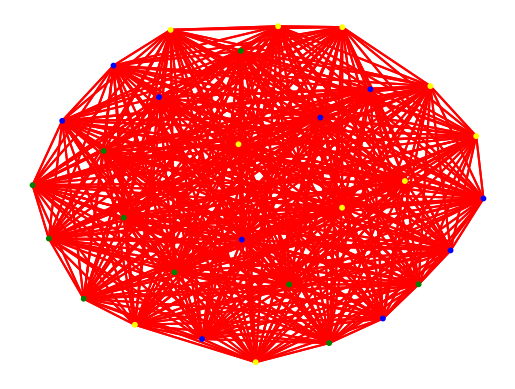

In [ ]:
pp.plot(graph.to_static_graph(), layout=layout_adam, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_torch, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_paper, backend='matplotlib', **style)